# UZOP projekt 2022./23.
Ova Jupyter bilježnica rezultat je projektnog rada u sklopu kolegija Uvod u znanost podacima na FER-u, ak. god. 2022./23. U sklopu projektnog zadatka zadan je članak s određenom temom iz područja znanosti o podacima, skupa sa svojim podacima koje je potrebno pripremiti, pomoću njih replicirati rezultate rada u članku te naposlijetku predložiti eventualna poboljšanja. U poglavljima koja slijede svi su ovi koraci prikazani uz prikladna objašnjenja.

Autor članka "Predicting NBA shots" na kojem se temelji ovaj projekt je Brett Meehan sa sveučilišta Stanford u SAD-u. Članak je javno dostupan na poveznici: http://cs229.stanford.edu/proj2017/final-reports/5132133.pdf. Članak istražuje primjenu različitih algoritama strojnog učenja na problem predviđanja uspješnosti bacanja igrača u NBA ligi.

## 1. Priprema i vizualizacija podataka
Prije bilo kakvog rada s podacima, potrebno je upoznati se s njima kako bismo ih mogli ispravno prikazati, koristiti i na temelju njih nešto zaključiti. Korištenje tzv. sirovih podataka u statističkoj analizi bez dubljeg promišljanja o njima može prouzročiti razne probleme, samo neki od kojih su neispravno postavljanje cilja analize, rušenje algoritama strojnog učenja te na koncu i donošenje neispravnih zaključaka.

Priprema podataka podrazumijeva njihovu pripremu za daljnju analizu. Tek nakon provedene pripreme možemo podatke organizirati i eventualno upotpuniti ukoliko ima nedostajućih vrijednosti. Naposlijetku je podatke poželjno vizualizirati.

### 1.1 Učitavanje osnovnih biblioteka


In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

### 1.2 Učitavanje podataka
Podaci su nam dostupni u obliku CSV datoteke `shot_logs.csv`.

In [311]:
dataset = pd.read_csv("shot_logs.csv")

### 1.3 Početni pregled podataka

Pomoću atributa `shape` možemo doznati dimenzije skupa podataka - u našem slučaju, to su dvije dimenzija: broj redaka (primjera) i broj stupaca (značajki).

In [312]:
dataset.shape

(128069, 21)

Funkcija `head(n=5)` iz paketa `Pandas` omogućuje nam prikaz prvih `n` redaka iz skupa podataka.

In [313]:
dataset.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Kako naš skup podataka ima dvije dimenzije, njegovo svojstvo `columns` ima atribut `values` preko kojeg doznajemo nazive svih značajki u našem skupu podataka. Ovo nam je važno jer ćemo neke značajke morati izbaciti, a neke će nam pak biti važnije od ostalih u predviđanjima nad skupom podataka.

In [314]:
dataset.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'player_name', 'player_id'], dtype=object)

Pomoću funkcije `info()` nad našim skupom podataka možemo doznati kojeg su tipa pojedine značajke.

In [315]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

U nastavku su dana pojašnjenja naziva pojedinih značajki:
- `GAME_ID` - identifikacijska oznaka utakmice
- `MATCHUP` - "naziv" utakmice, koji uključuje datum i imena suprotstavljenih timova
- `LOCATION` - lokacija na kojoj je odigrana utakmica, može biti `H` (_home_) ili `A` (_away_)
- `W` - ishod utakmice, može biti `W` (_win_) ili `L` (_loss_)
- `FINAL_MARGIN` - razlika u ostvarenim poenima između pobjedničkog i gubitničkog tima na kraju utakmice
- `SHOT_NUMBER` - redni broj pucanja za dotičnog igrača
- `PERIOD` - dio utakmice, može biti prirodan broj iz skupa {1, 2, 3, 4} i označava redni broj četvrtine
- `GAME_CLOCK` - vrijeme u trenutku pucanja na satu koji označava preostalo vrijeme do kraja trenutne četvrtine
- `SHOT_CLOCK` - vrijeme u trenutku pucanja na satu koji označava preostalo vrijeme za napad
- `DRIBBLES` - broj driblanja igrača prije pucanja na koš
- `TOUCH_TIME` - mjera vremena koliko je lopta provela u igračevom posjedu
- `SHOT_DIST` - udaljenost mjesta pucanja od koša
- `PTS_TYPE` - vrsta pucanja koja zapravo označava broj poena koje igrač osvaja za svoj tim u slučaju pogotka, može biti prirodan broj iz skupa {2, 3}
- `SHOT_RESULT` - ishod pucanja, može biti `made` (pogodak) ili `missed` (promašaj)
- `CLOSEST_DEFENDER` - ime protivničkog obrambenog igrača koji se u trenutku pucanja nalazio najbliže igraču koji puca
- `CLOSEST_DEFENDER_PLAYERID` - id protivničkog obrambenog igrača koji se u trenutku pucanja nalazio najbliže igraču koji puca
- `CLOSE_DEF_DIST` - udaljenost najbližeg protivničkog obrambenog igrača od igrača koji puca
- `FGM` - označava je li postignut pogodak koji nije iz slobodnog bacanja, može biti `1` (pogodak postignut) ili `0` (pogodak nije postignut)
- `PTS` - ostvareni broj poena za pogodak, može biti cijeli broj iz skupa {0, 1, 2, 3}
- `player_name` - ime igrača koji puca
- `player_id` - identifikacijska oznaka igrača koji puca

U nastavku su pomoću funkcije `describe()` dane neke osnovne deskriptivne statistike nad skupom podataka.

In [316]:
dataset.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [317]:
dataset.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

Podatke koji nam ne mogu pomoći u statističkoj analizi podataka potrebno je izbaciti iz skupa. Kandidati za izbacivanje su `MATCHUP` (jer je to samo naziv utakmice za koju već imamo jedinstveni identifikator), `CLOSEST_DEFENDER` (jer je to ime igrača za kojeg imamo jedinstveni identifikator) i `player_name` (isto opravdanje).

In [318]:
dataset.drop(('MATCHUP'), axis=1, inplace=True)
dataset.drop(('CLOSEST_DEFENDER'), axis=1, inplace=True)
dataset.drop(('player_name'), axis=1, inplace=True)

Također, može se argumentirati da najbližeg obrambenog igrača možemo u potpunosti izbaciti te gledati samo njegovu udaljenost od igrača koji puca. Razlog tomu je što nemamo puno konzistentnih podataka - npr. da se svi zapisi u skupu odnose na jednog igrača i njegova pucanja, ili barem igrače iz istog tima, imalo bi smisla promatrati protiv kojih obrambenih igrača oni bolje odnosno lošije funkcioniraju u napadu.

In [319]:
dataset.drop(('CLOSEST_DEFENDER_PLAYER_ID'), axis=1, inplace=True)

In [320]:
dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


### 1.4 Preoblikovanje podataka
U skupu podataka ima nedostajućih vrijednosti, što otežava kasniju obradu i vizualizaciju. Nekoliko je načina razrješavanja nedostajućih vrijednosti u skupu podataka: izbacivanje zapisa iz skupa podataka, izbacivanje značajke iz skupa podataka, zamjena srednjom vrijednošću preostalih vrijednosti, pronalazak točnih vrijednosti na drugim mjestima itd.

Možemo pronaći nedostajuće vrijednosti u našem skupu podataka pomoću funkcije `isna()` koja traži vrijednosti `NaN` u skupu podataka. Broj pojavljivanja takvih vrijednosti pobrojimo po značajkama pomoću funkcije `sum()`.

In [321]:
dataset.isna().sum()

GAME_ID              0
LOCATION             0
W                    0
FINAL_MARGIN         0
SHOT_NUMBER          0
PERIOD               0
GAME_CLOCK           0
SHOT_CLOCK        5567
DRIBBLES             0
TOUCH_TIME           0
SHOT_DIST            0
PTS_TYPE             0
SHOT_RESULT          0
CLOSE_DEF_DIST       0
FGM                  0
PTS                  0
player_id            0
dtype: int64

Značajka `GAME_CLOCK` neprikladnog je formata za računanje pa bi bilo dobro prebaciti ju u sekunde.

In [322]:
dataset["GAME_CLOCK"] = pd.to_datetime(dataset["GAME_CLOCK"])
dataset["GAME_CLOCK"] = dataset["GAME_CLOCK"].dt.minute + 60 * dataset["GAME_CLOCK"].dt.hour
dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,W,24,1,1,69,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,W,24,2,1,14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,W,24,3,1,0,NaN,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,W,24,4,2,707,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,W,24,5,2,634,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


Vidimo da u našem skupu podataka značajka `SHOT_CLOCK` ima nedostajućih vrijednosti.

In [323]:
dataset_shotClockNaN = dataset[dataset["SHOT_CLOCK"].isna()]
dataset_shotClockNaN.loc[:, ["GAME_CLOCK", "SHOT_CLOCK"]]

,GAME_CLOCK,SHOT_CLOCK
2,0,NaN
24,4,NaN
54,1,NaN
76,1,NaN
129,2,NaN
...,...,...
128008,2,NaN
128017,3,NaN
128018,2,NaN
128051,16,NaN


Iz navedenog prikaza možemo zaključiti da se _shot clock_ više ne resetira nakon što _game clock_ vrijednost padne ispod 24 sekunde. Nakon što dođe do nule, shot clock se ugasi jer igrači od tog trenutka više nemaju 24 sekunde na raspolaganju za napad, već onoliko koliko je preostalo do kraja četvrtine.

Vrijednosti `NaN` u stupcu značajke `SHOT_CLOCK` možemo zamijeniti vrijednošću značajke `GAME_CLOCK`. Nema smisla izbacivati te zapise iz skupa podataka jer ih ima puno, a značajku pogotovo nema smisla izbacivati jer igrači imaju tendenciju pucati kada je vrijednost na _shot clocku_ mala.

In [324]:
mask = (dataset['SHOT_CLOCK'].isna())
dataset.loc[mask, "SHOT_CLOCK"] = dataset.loc[mask, "GAME_CLOCK"]

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,W,24,1,1,69,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,W,24,2,1,14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,W,24,3,1,0,0.0,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,W,24,4,2,707,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,W,24,5,2,634,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


Vidimo da u stupcu `SHOT_CLOCK` više nema nedostajućih vrijednosti, već su one sada zamijenjene vrijednošću iz stupca `GAME_CLOCK`.

Značajka `TOUCH_TIME` za neke primjere poprima negativne vrijednosti, što ne može biti točno. Provjerimo koliko ima takvih primjera u našem skupu podataka.

In [325]:
dataset_touchTimeNegative = dataset[dataset["TOUCH_TIME"] < 0]
print(dataset_touchTimeNegative.size)

5304


S obzirom na to da je udio ovih primjera u skupu podataka relativno malen, možemo ih izbaciti iz skupa podataka.

In [326]:
dataset = dataset.loc[dataset["TOUCH_TIME"] >= 0]

Neke značajke ne možemo koristiti u statističkoj analizi kao takve, već im vrijednosti moramo postaviti u numeričke, odnosno brojeve. Na primjer, značajka `W` poprima vrijednosti `W` i `L`, što lako možemo preoblikovati u `1` i `0`.

In [327]:
mask = (dataset['W'] == 'W')
dataset.loc[mask, "W"] = 1

mask = (dataset['W'] == 'L')
dataset.loc[mask, "W"] = 0

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,1,24,1,1,69,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,1,24,2,1,14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,1,24,3,1,0,0.0,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,1,24,4,2,707,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,1,24,5,2,634,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


Isto možemo učiniti i sa značajkama `LOCATION` i `SHOT_RESULT`.

In [328]:
mask = (dataset['LOCATION'] == 'H')
dataset.loc[mask, "LOCATION"] = 1

mask = (dataset['LOCATION'] == 'A')
dataset.loc[mask, "LOCATION"] = 0

mask = (dataset['SHOT_RESULT'] == 'made')
dataset.loc[mask, "SHOT_RESULT"] = 1

mask = (dataset['SHOT_RESULT'] == 'missed')
dataset.loc[mask, "SHOT_RESULT"] = 0

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,0,1,24,1,1,69,10.8,2,1.9,7.7,2,1,1.3,1,2,203148
1,21400899,0,1,24,2,1,14,3.4,0,0.8,28.2,3,0,6.1,0,0,203148
2,21400899,0,1,24,3,1,0,0.0,3,2.7,10.1,2,0,0.9,0,0,203148
3,21400899,0,1,24,4,2,707,10.3,2,1.9,17.2,2,0,3.4,0,0,203148
4,21400899,0,1,24,5,2,634,10.9,2,2.7,3.7,2,0,1.1,0,0,203148


Sada kada smo "numerizirali" značajku `SHOT_MADE`, možemo argumentirati izbacivanje značajke `FGM` pošto ona označava je li postignut pogodak koji nije bio rezultat slobodnog bacanja, što nam je manje važno od činjenice da je igrač postigao pogodak.

In [329]:
dataset.drop(('FGM'), axis=1, inplace=True)

In [330]:
dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS,player_id
0,21400899,0,1,24,1,1,69,10.8,2,1.9,7.7,2,1,1.3,2,203148
1,21400899,0,1,24,2,1,14,3.4,0,0.8,28.2,3,0,6.1,0,203148
2,21400899,0,1,24,3,1,0,0.0,3,2.7,10.1,2,0,0.9,0,203148
3,21400899,0,1,24,4,2,707,10.3,2,1.9,17.2,2,0,3.4,0,203148
4,21400899,0,1,24,5,2,634,10.9,2,2.7,3.7,2,0,1.1,0,203148


### 1.5 Vizualizacija podataka
Vizualizacija podataka omogućuje nam otkrivanje odnosa među varijablama i primjercima te bolje razumijevanja rezultata analize. Vrlo je bitna za općenito razumijevanje skupa podataka s kojim raspolažemo pa je samim time neizostavan dio pregleda podataka.

Za početak ćemo pokušati detektirati stršeće vrijednosti u skupu podataka. To možemo učiniti pomoću funkcije `boxplot()`.

Text(0.5, 1.0, 'Closest defender distance')

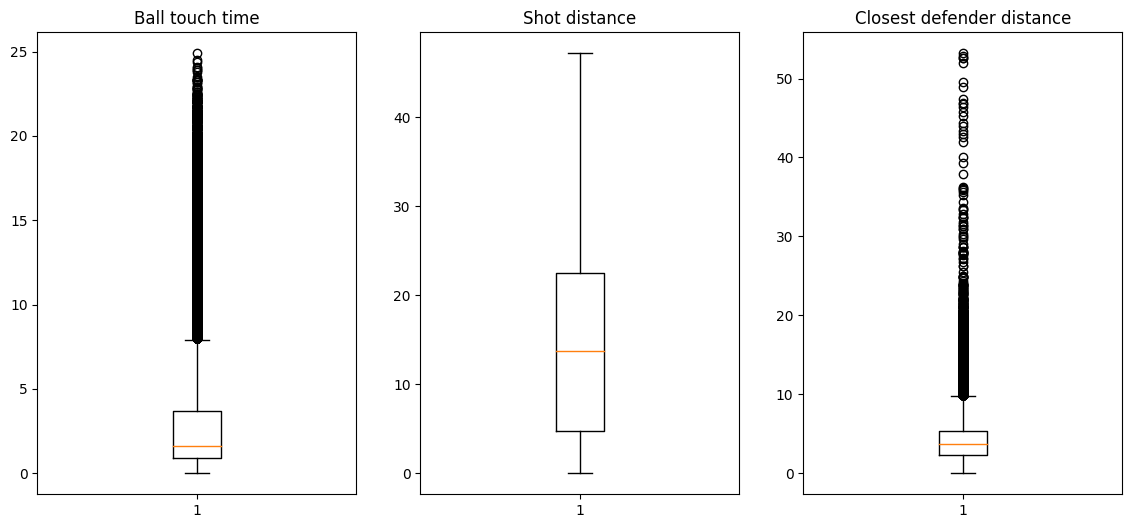

In [331]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
ax[0].boxplot(dataset['TOUCH_TIME'])
ax[0].set_title("Ball touch time")
ax[1].boxplot(dataset['SHOT_DIST'])
ax[1].set_title("Shot distance")
ax[2].boxplot(dataset['CLOSE_DEF_DIST'])
ax[2].set_title("Closest defender distance")

Provjerit ćemo i koje bi vrijednosti mogle biti korelirane na temelju matrice korelacija koju dobijemo pomoću funkcije `corr()`.

In [332]:
dataset.corr()

/var/folders/n_/4mscf3ld1n9g7nqmvt59wr3c0000gn/T/ipykernel_6379/2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PTS,player_id
GAME_ID,1.000000,0.001571,0.008284,-0.008819,0.003050,0.004329,0.001938,-0.000906,-0.000411,0.003336,0.006646,-0.008445,0.027689
FINAL_MARGIN,0.001571,1.000000,0.000735,-0.003007,0.005967,-0.002850,0.011703,0.011191,0.008983,0.024077,0.033059,0.064867,-0.050677
SHOT_NUMBER,0.008284,0.000735,1.000000,0.654968,-0.237954,-0.053113,0.141385,0.146994,0.011704,0.003055,-0.037666,-0.009712,-0.006464
PERIOD,-0.008819,-0.003007,0.654968,1.000000,-0.027180,-0.039699,0.055311,0.046634,0.030186,0.048868,-0.010090,-0.008511,0.004854
GAME_CLOCK,0.003050,0.005967,-0.237954,-0.027180,1.000000,0.079111,-0.116415,-0.104881,-0.021836,-0.048530,0.007467,0.006762,-0.006223
SHOT_CLOCK,0.004329,-0.002850,-0.053113,-0.039699,0.079111,1.000000,-0.025941,-0.030640,-0.018781,-0.007315,0.002541,0.008307,-0.005823
DRIBBLES,0.001938,0.011703,0.141385,0.055311,-0.116415,-0.025941,1.000000,0.930624,-0.083039,-0.169628,-0.154152,-0.056165,0.023756
TOUCH_TIME,-0.000906,0.011191,0.146994,0.046634,-0.104881,-0.030640,0.930624,1.000000,-0.086741,-0.185478,-0.167395,-0.069994,0.001924
SHOT_DIST,-0.000411,0.008983,0.011704,0.030186,-0.021836,-0.018781,-0.083039,-0.086741,1.000000,0.741290,0.522937,-0.069781,-0.024247
PTS_TYPE,0.003336,0.024077,0.003055,0.048868,-0.048530,-0.007315,-0.169628,-0.185478,0.741290,1.000000,0.414350,0.030011,0.010594


Vidimo da postoji koreliranost između značajki `PTS_TYPE` i `CLOSE_DEF_DIST`. To možemo objasniti ako zamislimo situaciju gdje igrač odlučuje gađati "tricu" - tada je manje vjerojatno da mu je u blizini neki obrambeni igrač, pogotovo ako igrač puca dalje od linije za tri poena. Također, u obrnutoj situaciji gdje se igrač probija do koša, gotovo sigurno će mu se neki obrambeni igrač naći jako blizu.

Još je nekoliko varijabli očito korelirano: `PERIOD` i `SHOT_NUMBER`, `TOUCH_TIME` i `DRIBBLES`, `PTS_TYPE` i `SHOT_DIST` te `CLOSE_DEF_DIST` i `SHOT_DIST`.

Ovo se još bolje vidi ako koristimo tzv. _heatmap_ funkcije.

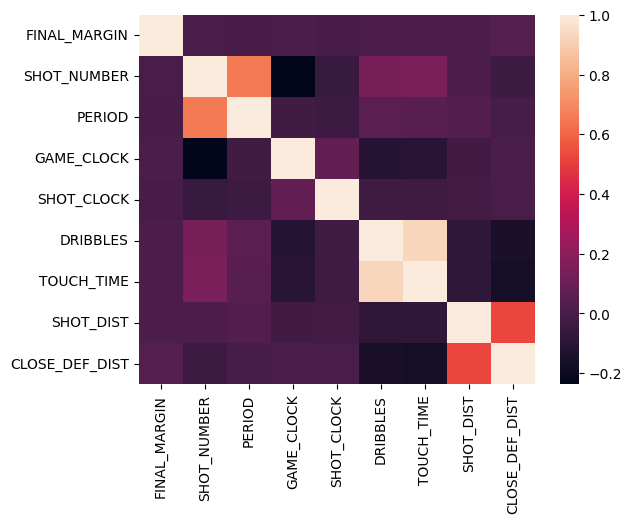

In [333]:
dataset_numeric = dataset.loc[:,dataset.columns.isin(['FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST'])]
sns.heatmap(dataset_numeric.corr())
plt.show()

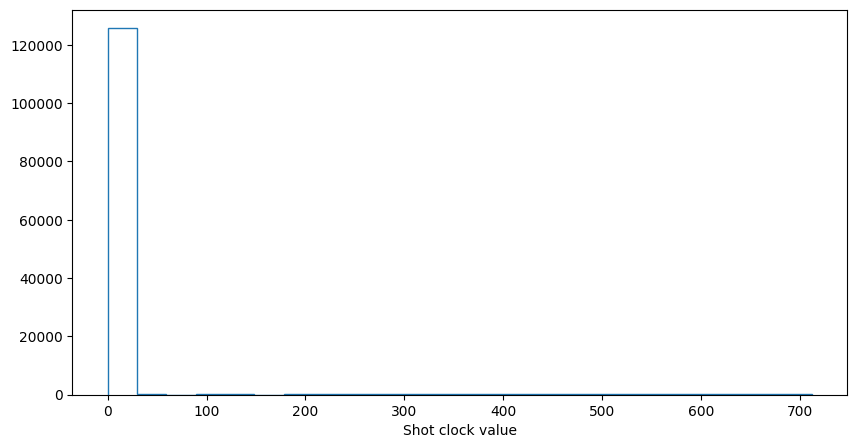

In [334]:
dataset['SHOT_CLOCK'] = pd.to_numeric(dataset['SHOT_CLOCK'],errors='coerce')

plt.figure(figsize=(10,5))
plt.hist(dataset['SHOT_CLOCK'], bins=24, histtype='step')
plt.xlabel('Shot clock value')
plt.show()

Vidimo da igrači imaju tendenciju pucati kada se vrijeme za napad približava kraju, što ima smisla jer žele iskoristiti priliku za postizanje pogotka.

# 2. Replikacija rezultata

U nastavku projekta korišteni su pristupi iz članka kako bi se postigla replikacija prikazanih rezultata. 

## 2.1 Uvod

Najveći izazov za sve pokušaje predviđanja ishoda pucanja na koš proizlazi iz relativno male količine informacija koje nam pružaju značajke. Osim nekolicine značajki poput udaljenosti igrača od koša i udaljenosti najbližeg protivničkog obrambenog igrača, značajke su uglavnom vrlo _high-level_, poput lokacije igre i preostalog vremena do kraja napada. Te značajke, iako nam govore manje o performansama pojedinog igrača u datom trenutku, i dalje mogu biti korisne pri predviđanju uspješnosti njegovog pucanja.

Donja ograda za uspješnost algoritma predviđanja može biti 50% - dakle, ako algoritam uspješno predvidi barem 50% ishoda, smatramo ga uspješnim.

Algoritmi strojnog učenja korišteni za predviđanje su: logistička regresija, stroj potpornih vektora, naivni Bayesov klasifikator, neuronske mreže i _boosting_. Ulaz algoritma strojnog učenja je u obliku vektora sljedećih značajki: lokacija utakmice, ishod utakmice, razlika u poenima na kraju utakmice, redni broj igračeva pucanja, četvrtina igre, vrijeme preostalo do kraja igre, vrijeme preostalo do kraja napada, broj driblanja, vrijeme diranja lopte (posjed), udaljenost igrača od koša u trenutku pucanja, udaljenost najbližeg protivničkog obrambenog igrača, ishod pucanja, broj postignutih poena, ime igrača i identifikacijska oznaka (ID) igrača.

Izlaz klasifikacijskih algoritama bit će 0 ili 1. U slučaju vjerojatnosnih izlaza, granica će biti postavljena na 0.5 te će svi primjeri za koje je izlaz manji od 0.5 dobiti oznaku 0, a ostali primjeri 1.

## 2.2 Skup podataka i značajke

Skup podataka korišten u članku preuzet je sa Kagglea i sadrži 122502 primjera pucanja iz 2014./15. sezone NBA lige. Za različite modele i metode predikcije prikladni su različiti tipovi podataka. Iz tog razloga, u nekim su postupcima iz skupa izbačeni kategorički podaci, a negdje su upravo takvi podaci bili dragocjeni pri predikciji uspješnosti pucanja.

## 2.3 Metode predikcije

### 2.3.1 Logistička regresija

S obzirom na to da je izlaz algoritma logističke regresije linearan set težina θ, iz skupa podataka izbacuju se kategoričke varijable koje imaju više od dva moguća izlaza (`GAME_ID`, `MATCHUP`, `CLOSEST_DEFENDER`, `CLOSEST_DEFENDER_PLAYER_ID`). Razlog tomu je da, kada se izlaz zamijeni cjelobrojnim vrijednostima, ti brojevi ne bi imali nikakvog značenja u kontekstu skupa podataka te bi samo "zbunili" model pri treniranju.

Kako bi se ipak sačuvao dio znanja koje nam pružaju značajke poput `GAME_PERIOD`, one su kombinirane s drugim, numeričkim značajkama. Konkretno, značajka `PERIOD` kombinirana je sa značajkom `GAME_CLOCK` u novu značajku `TOTAL_GAME_TIME` jer je potrebno napraviti razliku između kraja pojedinih četvrtina utakmice - na primjer, igrači su sigurno umorniji na kraju posljednje nego na kraju prve četvrtine.

Također su izlazi algoritma promijenjeni iz {0, 1} u {-1, 1}.

In [335]:
from sklearn.model_selection import train_test_split

# Ucitavanje podataka.
T = pd.read_csv("shot_logs.csv")

# Uklanjanje kategorickih varijabli s vise od dvije vrijednosti.
T.drop(('GAME_ID'), axis=1, inplace=True)
T.drop(('MATCHUP'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER_PLAYER_ID'), axis=1, inplace=True)
T.drop(('FGM'), axis=1, inplace=True)
T.drop(('PTS'), axis=1, inplace=True)
T.drop(('player_name'), axis=1, inplace=True)
T.drop(('player_id'), axis=1, inplace=True)

# Zamjena vrijednosti NaN u SHOT_CLOCK stupcu nulom.
mask = (T['SHOT_CLOCK'].isna())
T.loc[mask, "SHOT_CLOCK"] = 0

# Kombiniranje stupaca PERIOD i GAME_CLOCK.
T["PERIOD"] = (T["PERIOD"] - 1) * (12 * 60)
T["GAME_CLOCK"] = pd.to_datetime(T["GAME_CLOCK"])
T["GAME_CLOCK"] = T["GAME_CLOCK"].dt.minute + 60 * T["GAME_CLOCK"].dt.hour
T["GAME_CLOCK"] = pd.to_numeric(T["GAME_CLOCK"])
T["GAME_TIME"] = T["PERIOD"] + T["GAME_CLOCK"]
T.drop(('PERIOD'), axis=1, inplace=True)
T.drop(('GAME_CLOCK'), axis=1, inplace=True)

# Zamjena H i A vrijednosti u stupcu LOCATION, L i W vrijednosti u stupcu W te 'missed' i 'made' vrijednosti
# u stupcu SHOT_RESULT vrijednostima -1 i 1.
mask = (T['LOCATION'] == 'H')
T.loc[mask, 'LOCATION'] = -1
mask = (T['LOCATION'] == 'A')
T.loc[mask, 'LOCATION'] = 1
mask = (T['W'] == 'L')
T.loc[mask, 'W'] = -1
mask = (T['W'] == 'W')
T.loc[mask, 'W'] = 1
mask = (T['SHOT_RESULT'] == 'missed')
T.loc[mask, 'SHOT_RESULT'] = -1
mask = (T['SHOT_RESULT'] == 'made')
T.loc[mask, 'SHOT_RESULT'] = 1

# Postavljanje stupca SHOT_RESULT na pocetak tablice.
shotResultColumn = T.pop('SHOT_RESULT')
T.insert(0, 'SHOT_RESULT', shotResultColumn)

# Pohrana nove tablice u zasebnu .csv datoteku.
T.to_csv('shot_logs_logistic.csv', index=False)

# Razdvajanje skupa podataka na skup za ucenje i skup za ispitivanje u omjeru 95/5.
T_train, T_test = train_test_split(T, train_size=0.3, test_size=0.015)
T_train.to_csv('logistic_train.csv', index=False)
T_test.to_csv('logistic_test.csv', index=False)

T.head()

,SHOT_RESULT,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,GAME_TIME
0,1,1,1,24,1,10.8,2,1.9,7.7,2,1.3,69
1,-1,1,1,24,2,3.4,0,0.8,28.2,3,6.1,14
2,-1,1,1,24,3,0.0,3,2.7,10.1,2,0.9,0
3,-1,1,1,24,4,10.3,2,1.9,17.2,2,3.4,1427
4,-1,1,1,24,5,10.9,2,2.7,3.7,2,1.1,1354


Izlaz modela logističke regresije ograničen je na raspon [0, 1] jer je sigmoidalna funkcija omotana oko skalarnog umnoška vektora težina i vektora značajki ulaznog primjera. Vektor težina dobiven je učenjem modela na skupu primjera za učenje, a ulazni primjeri dolaze iz skupa za ispitivanje.

In [336]:
from sklearn.linear_model import LogisticRegression

# Ucitavanje skupa podataka za ucenje.
T_train = pd.read_csv("logistic_train.csv")
T_train = T_train.to_numpy()

# Razdvajanje primjera za ucenje od njihovih oznaka.
X_train = T_train[:, 1:]
y_train = T_train[:, 0]

# Model L2-regularizirane logisticke regresije.
logisticRegression = LogisticRegression(penalty='l2', tol=0.001, C=100, fit_intercept=True, max_iter=2000)
logisticRegression.fit(X_train, y_train)

# plot_2d_clf_problem(X_train, y_train, lambda x : logisticRegression.predict(x))

# Ucitavanje skupa podataka za ispitivanje.
T_test = pd.read_csv("logistic_test.csv")
T_test = T_test.to_numpy()

# Razdvajanje primjera za ispitivanje od njihovih oznaka.
X_test = T_test[:, 1:]
y_test = T_test[:, 0]

predictions_lr = logisticRegression.predict(X_test)
acc_lr = 0
for i in range(predictions_lr.shape[0]):
    if(predictions_lr[i] == y_test[i]):
        acc_lr += 1
acc_lr /= predictions_lr.shape[0]

print("Model L2 - regularizirane logističke regresije uspješno je klasificirao {:.2f}% ispitnih primjera.".format(acc_lr * 100))

Model L2 - regularizirane logističke regresije uspješno je klasificirao 60.51% ispitnih primjera.


### 2.3.2 Stroj potpornih vektora

Stroj potpornih vektora sofisticiran je klasifikacijski algoritam koji ima induktivnu pristranost da maksimizira marginu, odnosno udaljenost granice između klasa od najbližih primjera s obje strane. To omogućuje dobru generalizaciju, a klasifikacija novih primjera određuje se na temelju sličnosti dotičnog primjera i potpornih vektora, kojih ima minimalno po jedan za svaku klasu. Sličnost se izražava vektorskim umnoškom ulaznog primjera i potpornih vektora.

Za klasifikaciju pomoću modela stroja potpornih vektora, podatke pripremamo na isti način kao i za model logističke regresije. Kod SVM-a očekujemo malo bolje rezultate jer je on u stanju generirati dodatne primjere pomoću jezgrenog trika.

In [337]:
from sklearn.model_selection import train_test_split

# Ucitavanje podataka.
T = pd.read_csv("shot_logs.csv")

# Uklanjanje kategorickih varijabli s vise od dvije vrijednosti.
T.drop(('GAME_ID'), axis=1, inplace=True)
T.drop(('MATCHUP'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER_PLAYER_ID'), axis=1, inplace=True)
T.drop(('FGM'), axis=1, inplace=True)
T.drop(('PTS'), axis=1, inplace=True)
T.drop(('player_name'), axis=1, inplace=True)
T.drop(('player_id'), axis=1, inplace=True)

# Zamjena vrijednosti NaN u SHOT_CLOCK stupcu nulom.
mask = (T['SHOT_CLOCK'].isna())
T.loc[mask, "SHOT_CLOCK"] = 0

# Kombiniranje stupaca PERIOD i GAME_CLOCK.
T["PERIOD"] = (T["PERIOD"] - 1) * (12 * 60)
T["GAME_CLOCK"] = pd.to_datetime(T["GAME_CLOCK"])
T["GAME_CLOCK"] = T["GAME_CLOCK"].dt.minute + 60 * T["GAME_CLOCK"].dt.hour
T["GAME_CLOCK"] = pd.to_numeric(T["GAME_CLOCK"])
T["GAME_TIME"] = T["PERIOD"] + T["GAME_CLOCK"]
T.drop(('PERIOD'), axis=1, inplace=True)
T.drop(('GAME_CLOCK'), axis=1, inplace=True)

# Zamjena H i A vrijednosti u stupcu LOCATION, L i W vrijednosti u stupcu W te 'missed' i 'made' vrijednosti
# u stupcu SHOT_RESULT vrijednostima -1 i 1.
mask = (T['LOCATION'] == 'H')
T.loc[mask, 'LOCATION'] = -1
mask = (T['LOCATION'] == 'A')
T.loc[mask, 'LOCATION'] = 1
mask = (T['W'] == 'L')
T.loc[mask, 'W'] = -1
mask = (T['W'] == 'W')
T.loc[mask, 'W'] = 1
mask = (T['SHOT_RESULT'] == 'missed')
T.loc[mask, 'SHOT_RESULT'] = -1
mask = (T['SHOT_RESULT'] == 'made')
T.loc[mask, 'SHOT_RESULT'] = 1

# Postavljanje stupca SHOT_RESULT na početak tablice.
shotResultColumn = T.pop('SHOT_RESULT')
T.insert(0, 'SHOT_RESULT', shotResultColumn)

# Pohrana nove tablice u zasebnu .csv datoteku.
T.to_csv('shot_logs_svm.csv', index=False)

# Razdvajanje skupa podataka na skup za ucenje i skup za ispitivanje u omjeru 95/5.
T_train, T_test = train_test_split(T, train_size=0.3, test_size=0.015)
T_train.to_csv('svm_train.csv', index=False)
T_test.to_csv('svm_test.csv', index=False)

T.head()

,SHOT_RESULT,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,GAME_TIME
0,1,1,1,24,1,10.8,2,1.9,7.7,2,1.3,69
1,-1,1,1,24,2,3.4,0,0.8,28.2,3,6.1,14
2,-1,1,1,24,3,0.0,3,2.7,10.1,2,0.9,0
3,-1,1,1,24,4,10.3,2,1.9,17.2,2,3.4,1427
4,-1,1,1,24,5,10.9,2,2.7,3.7,2,1.1,1354


In [338]:
from sklearn.svm import SVC

# Ucitavanje skupa podataka za ucenje.
T_train = pd.read_csv("svm_train.csv")
T_train = T_train.to_numpy()

# Razdvajanje primjera za ucenje od njihovih oznaka.
X_train = T_train[:, 1:]
y_train = T_train[:, 0]

# Model stroja potpornih vektora.
svc = SVC()
svc.fit(X_train, y_train)

# Ucitavanje skupa podataka za ispitivanje.
T_test = pd.read_csv("svm_test.csv")
T_test = T_test.to_numpy()

# Razdvajanje primjera za ispitivanje od njihovih oznaka.
X_test = T_test[:, 1:]
y_test = T_test[:, 0]

predictions_svm = svc.predict(X_test)
acc_svm = 0
for i in range(predictions_svm.shape[0]):
    if(predictions_svm[i] == y_test[i]):
        acc_svm += 1
acc_svm /= predictions_svm.shape[0]

print("Model stroja potpornih vektora uspješno je klasificirao {:.2f}% ispitnih primjera.".format(acc_svm * 100))

Model stroja potpornih vektora uspješno je klasificirao 54.47% ispitnih primjera.


### 2.3.3 Neuronske mreže

Model neuronske mreže koristi čvorove, tzv. _perceptrone_, koji u svakom sloju mreže uče težine i na taj način kreiraju nelinearni izlaz modela. Za aktivacijsku funkciju izlaza pojedinih čvorova odabrana je sigmoidalna funkcija odnosno sigmoida pa je za funkciju gubitka odabran gubitak logističke regresije.

In [339]:
from sklearn.model_selection import train_test_split

# Ucitavanje podataka.
T = pd.read_csv("shot_logs.csv")

# Uklanjanje kategorickih varijabli s vise od dvije vrijednosti.
T.drop(('GAME_ID'), axis=1, inplace=True)
T.drop(('MATCHUP'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER'), axis=1, inplace=True)
T.drop(('CLOSEST_DEFENDER_PLAYER_ID'), axis=1, inplace=True)
T.drop(('FGM'), axis=1, inplace=True)
T.drop(('PTS'), axis=1, inplace=True)
T.drop(('player_name'), axis=1, inplace=True)
T.drop(('player_id'), axis=1, inplace=True)

# Zamjena vrijednosti NaN u SHOT_CLOCK stupcu nulom.
mask = (T['SHOT_CLOCK'].isna())
T.loc[mask, "SHOT_CLOCK"] = 0

# Kombiniranje stupaca PERIOD i GAME_CLOCK.
T["PERIOD"] = (T["PERIOD"] - 1) * (12 * 60)
T["GAME_CLOCK"] = pd.to_datetime(T["GAME_CLOCK"])
T["GAME_CLOCK"] = T["GAME_CLOCK"].dt.minute + 60 * T["GAME_CLOCK"].dt.hour
T["GAME_CLOCK"] = pd.to_numeric(T["GAME_CLOCK"])
T["GAME_TIME"] = T["PERIOD"] + T["GAME_CLOCK"]
T.drop(('PERIOD'), axis=1, inplace=True)
T.drop(('GAME_CLOCK'), axis=1, inplace=True)

# Zamjena H i A vrijednosti u stupcu LOCATION, L i W vrijednosti u stupcu W te 'missed' i 'made' vrijednosti
# u stupcu SHOT_RESULT vrijednostima -1 i 1.
mask = (T['LOCATION'] == 'H')
T.loc[mask, 'LOCATION'] = -1
mask = (T['LOCATION'] == 'A')
T.loc[mask, 'LOCATION'] = 1
mask = (T['W'] == 'L')
T.loc[mask, 'W'] = -1
mask = (T['W'] == 'W')
T.loc[mask, 'W'] = 1
mask = (T['SHOT_RESULT'] == 'missed')
# Razlika u odnosu na prethodne modele - izlaz je 0 ili 1.
T.loc[mask, 'SHOT_RESULT'] = 0
mask = (T['SHOT_RESULT'] == 'made')
T.loc[mask, 'SHOT_RESULT'] = 1

# Postavljanje stupca SHOT_RESULT na početak tablice.
shotResultColumn = T.pop('SHOT_RESULT')
T.insert(0, 'SHOT_RESULT', shotResultColumn)

# Pohrana nove tablice u zasebnu .csv datoteku.
T.to_csv('shot_logs_neural.csv', index=False)

# Razdvajanje skupa podataka na skup za ucenje i skup za ispitivanje u omjeru 95/5.
T_train, T_test = train_test_split(T, train_size=0.3, test_size=0.015)
T_train.to_csv('neural_train.csv', index=False)
T_test.to_csv('neural_test.csv', index=False)

T.head()

,SHOT_RESULT,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,GAME_TIME
0,1,1,1,24,1,10.8,2,1.9,7.7,2,1.3,69
1,0,1,1,24,2,3.4,0,0.8,28.2,3,6.1,14
2,0,1,1,24,3,0.0,3,2.7,10.1,2,0.9,0
3,0,1,1,24,4,10.3,2,1.9,17.2,2,3.4,1427
4,0,1,1,24,5,10.9,2,2.7,3.7,2,1.1,1354


Korištene su dvije neuronske mreže. Prva neuronska mreža kao kao aktivacijsku funkciju izlaza svih čvorova koristi sigmoidalnu funkciju, a druga je u skrivenim čvorovima koristi RELU, a sigmoidalnu funkciju u izlaznom sloju.

In [340]:
from sklearn.neural_network import MLPClassifier

# Ucitavanje skupa podataka za ucenje.
T_train = pd.read_csv("neural_train.csv")
T_train = T_train.to_numpy()

# Razdvajanje primjera za ucenje od njihovih oznaka.
X_train = T_train[:, 1:]
y_train = T_train[:, 0]

# Model neuronske mreze.
mlp = MLPClassifier(hidden_layer_sizes=50, activation='logistic', alpha=0.0001, learning_rate_init=5)
mlp.fit(X_train, y_train)

# Ucitavanje skupa podataka za ispitivanje.
T_test = pd.read_csv("neural_test.csv")
T_test = T_test.to_numpy()

# Razdvajanje primjera za ispitivanje od njihovih oznaka.
X_test = T_test[:, 1:]
y_test = T_test[:, 0]

predictions_mlp = mlp.predict(X_test)
acc_mlp = 0
for i in range(predictions_mlp.shape[0]):
    if(predictions_mlp[i] == y_test[i]):
        acc_mlp += 1
acc_mlp /= predictions_mlp.shape[0]

print("Model neuronske mreže uspješno je klasificirao {:.2f}% ispitnih primjera.".format(acc_mlp * 100))

Model neuronske mreže uspješno je klasificirao 46.83% ispitnih primjera.


### 2.3.4 Naivni Bayesov klasifikator

Naivni Bayesov klasifikator jednostavan je klasifikacijski model koji počiva na pretpostavci da su sve značajke iz vektora `x` uvjetno nezavisne s obzirom na izlaz modela `y`. S obzirom na to da dio značajki ima više od dvije moguće vrijednosti, korišten je multinomijalni model.

In [341]:
from sklearn.model_selection import train_test_split

# Ucitavanje podataka.
T = pd.read_csv("shot_logs.csv")

# Uklanjanje kategorickih varijabli s vise od dvije vrijednosti.
T.drop(('FGM'), axis=1, inplace=True)
T.drop(('PTS'), axis=1, inplace=True)

# Zamjena vrijednosti NaN u SHOT_CLOCK stupcu nulom.
mask = (T['SHOT_CLOCK'].isna())
T.loc[mask, "SHOT_CLOCK"] = 0

# Konverzija vrijednosti GAME_CLOCK u sekunde.
T["GAME_CLOCK"] = pd.to_datetime(T["GAME_CLOCK"])
T["GAME_CLOCK"] = T["GAME_CLOCK"].dt.minute + 60 * T["GAME_CLOCK"].dt.hour
T["GAME_CLOCK"] = pd.to_numeric(T["GAME_CLOCK"])

# Postavljanje stupca SHOT_RESULT na početak tablice.
shotResultColumn = T.pop('SHOT_RESULT')
T.insert(0, 'SHOT_RESULT', shotResultColumn)

# Pohrana nove tablice u zasebnu .csv datoteku.
T.to_csv('shot_logs_naive_bayes.csv', index=False)

# Razdvajanje skupa podataka na skup za ucenje i skup za ispitivanje u omjeru 95/5.
T_train, T_test = train_test_split(T, train_size=0.3, test_size=0.015)
T_train.to_csv('naive_bayes_train.csv', index=False)
T_test.to_csv('naive_bayes_test.csv', index=False)

T.head()

,SHOT_RESULT,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_name,player_id
0,made,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,69,10.8,2,1.9,7.7,2,"Anderson, Alan",101187,1.3,brian roberts,203148
1,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,14,3.4,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,6.1,brian roberts,203148
2,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0,0.0,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,0.9,brian roberts,203148
3,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,707,10.3,2,1.9,17.2,2,"Brown, Markel",203900,3.4,brian roberts,203148
4,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,634,10.9,2,2.7,3.7,2,"Young, Thaddeus",201152,1.1,brian roberts,203148


In [342]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

# Ucitavanje skupa podataka za ucenje.
T_train = pd.read_csv("naive_bayes_train.csv")
T_train = T_train.to_numpy()

# Razdvajanje primjera za ucenje od njihovih oznaka.
X_train = T_train[:, 1:]
y_train = T_train[:, 0]

# Label encoding.
le = preprocessing.LabelEncoder()
for i in range(X_train.shape[1]):
    X_train[:, i] = le.fit_transform(X_train[:, i])

# Model neuronske mreze.
naiveBayes = MultinomialNB()
naiveBayes.fit(X_train, y_train)

# Ucitavanje skupa podataka za ispitivanje.
T_test = pd.read_csv("naive_bayes_test.csv")
T_test = T_test.to_numpy()

# Razdvajanje primjera za ispitivanje od njihovih oznaka.
X_test = T_test[:, 1:]
y_test = T_test[:, 0]

# Label encoding.
for i in range(X_test.shape[1]):
    X_test[:, i] = le.fit_transform(X_test[:, i])

predictions_nb = naiveBayes.predict(X_test)
acc_nb = 0
for i in range(predictions_nb.shape[0]):
    if(predictions_nb[i] == y_test[i]):
        acc_nb += 1
acc_nb /= predictions_nb.shape[0]

print("Naivni Bayesov klasifikator uspješno je klasificirao {:.2f}% ispitnih primjera.".format(acc_nb * 100))

Naivni Bayesov klasifikator uspješno je klasificirao 59.52% ispitnih primjera.


### 2.3.5 Slučajne šume

In [343]:
from sklearn.model_selection import train_test_split

# Ucitavanje podataka.
T = pd.read_csv("shot_logs.csv")

# Uklanjanje kategorickih varijabli s vise od dvije vrijednosti.
T.drop(('FGM'), axis=1, inplace=True)
T.drop(('PTS'), axis=1, inplace=True)

# Zamjena vrijednosti NaN u SHOT_CLOCK stupcu nulom.
mask = (T['SHOT_CLOCK'].isna())
T.loc[mask, "SHOT_CLOCK"] = 0

# Konverzija vrijednosti GAME_CLOCK u sekunde.
T["GAME_CLOCK"] = pd.to_datetime(T["GAME_CLOCK"])
T["GAME_CLOCK"] = T["GAME_CLOCK"].dt.minute + 60 * T["GAME_CLOCK"].dt.hour
T["GAME_CLOCK"] = pd.to_numeric(T["GAME_CLOCK"])

# Postavljanje stupca SHOT_RESULT na početak tablice.
shotResultColumn = T.pop('SHOT_RESULT')
T.insert(0, 'SHOT_RESULT', shotResultColumn)

# Pohrana nove tablice u zasebnu .csv datoteku.
T.to_csv('shot_logs_random_forest.csv', index=False)

# Razdvajanje skupa podataka na skup za ucenje i skup za ispitivanje u omjeru 70/30.
T_train, T_test = train_test_split(T, train_size=0.3, test_size=0.015)
T_train.to_csv('random_forest_train.csv', index=False)
T_test.to_csv('random_forest_test.csv', index=False)

T.head()

,SHOT_RESULT,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_name,player_id
0,made,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,69,10.8,2,1.9,7.7,2,"Anderson, Alan",101187,1.3,brian roberts,203148
1,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,14,3.4,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,6.1,brian roberts,203148
2,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0,0.0,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,0.9,brian roberts,203148
3,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,707,10.3,2,1.9,17.2,2,"Brown, Markel",203900,3.4,brian roberts,203148
4,missed,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,634,10.9,2,2.7,3.7,2,"Young, Thaddeus",201152,1.1,brian roberts,203148


In [344]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Ucitavanje skupa podataka za ucenje.
T_train = pd.read_csv("random_forest_train.csv")
T_train = T_train.to_numpy()

# Razdvajanje primjera za ucenje od njihovih oznaka.
X_train = T_train[:, 1:]
y_train = T_train[:, 0]

# Label encoding.
le = preprocessing.LabelEncoder()
for i in range(X_train.shape[1]):
    X_train[:, i] = le.fit_transform(X_train[:, i])

# Model slucajne sume.
randomForest = RandomForestClassifier(n_estimators=80, min_samples_leaf=50)
randomForest.fit(X_train, y_train)

# Ucitavanje skupa podataka za ispitivanje.
T_test = pd.read_csv("random_forest_test.csv")
T_test = T_test.to_numpy()

# Razdvajanje primjera za ispitivanje od njihovih oznaka.
X_test = T_test[:, 1:]
y_test = T_test[:, 0]

# Label encoding.
for i in range(X_test.shape[1]):
    X_test[:, i] = le.fit_transform(X_test[:, i])

predictions_rf = randomForest.predict(X_test)
acc_rf = 0
for i in range(predictions_rf.shape[0]):
    if(predictions_rf[i] == y_test[i]):
        acc_rf += 1
acc_rf /= predictions_nb.shape[0]

print("Model slučajnih šuma uspješno je klasificirao {:.2f}% ispitnih primjera.".format(acc_rf * 100))

Model slučajnih šuma uspješno je klasificirao 62.43% ispitnih primjera.


## 2.4 Rezultati

Model slučajnih šuma i naivni Bayesov klasifikator pokazali su se uspješnijima u klasifikaciji od logističke regresije, stroja potpornih vektora i neuronskih mreža. To je zato što ova dva modela uzimaju u obzir neke kategoričke značajke koje su u prva tri modela bile izbačene, a koje očito imaju znatan utjecaj na ishod pucanja. Možemo pretpostaviti da veliku ulogu u tome hoće li igrač pogoditi koš ima znanje o tome koji je to uopće igrač te koji se igrač nalazi u obrani protivničkog tima.

Model slučajnih šuma inače se smatra jednim od naprednijih klasifikacijskih algoritama, upravo zbog svog načina rada koji se oslanja na agregaciju rezultata nezavisnih dijelova algoritma (koji sami po sebi ne bi bili toliko uspješni) kako bi se postigao što točniji rezultat.

In [345]:
print("MODEL              ACCURACY")
print("Log. regression     {:.2f}%".format(acc_lr * 100))
print("SVM                 {:.2f}%".format(acc_svm * 100))
print("Neural network      {:.2f}%".format(acc_mlp * 100))
print("Naive Bayes         {:.2f}%".format(acc_nb * 100))
print("Random forest       {:.2f}%".format(acc_rf * 100))

MODEL              ACCURACY
Log. regression     60.51%
SVM                 54.47%
Neural network      46.83%
Naive Bayes         59.52%
Random forest       62.43%
